In [62]:
# How long will I be on hold?
#   - Which age group checks out the most books? Which age groups has the highest renewal rate (# ttl renewals/# ttl checkouts)
#   - Which library branch gets the most checkouts?
#   - Can the library branch and the average number of checkouts be used to estimate the age group of the patron?

# SF Library Data Analysis 

This analysis sets out to make observations about the San Francisco Library usage and its patrons,
in the ultimate quest to find the answer to the following question:
Who has my book? and does this give me any hints as to whether the book I want is going to be renewed?

In [63]:
#load libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

## Load Data  and Take a Look

In [64]:
# import DataSF dataset
df = pd.read_csv('Library_Usage.csv');
df.head()

,Patron Type Code,Patron Type Definition,Total Checkouts,Total Renewals,Age Range,Home Library Code,Home Library Definition,Circulation Active Month,Circulation Active Year,Notice Preference Code,Notice Preference Definition,Provided Email Address,Year Patron Registered,Outside of County,Supervisor District
0,3,SENIOR,28,13,65 to 74 years,X,Main Library,November,2012,z,email,True,2003,True,NaN
1,0,ADULT,21,10,55 to 59 years,X,Main Library,October,2015,z,email,True,2003,False,NaN
2,0,ADULT,275,559,60 to 64 years,X,Main Library,January,2015,z,email,True,2003,True,NaN
3,0,ADULT,73,38,45 to 54 years,M8,Mission Bay,February,2016,z,email,True,2003,False,NaN
4,0,ADULT,182,90,45 to 54 years,X,Main Library,July,2016,z,email,True,2003,False,NaN


In [65]:
#423448 records to start
df.shape

(423448, 15)

In [66]:
# What are the types of data we have to work with?
df.dtypes

Patron Type Code                  int64
Patron Type Definition           object
Total Checkouts                   int64
Total Renewals                    int64
Age Range                        object
Home Library Code                object
Home Library Definition          object
Circulation Active Month         object
Circulation Active Year          object
Notice Preference Code           object
Notice Preference Definition     object
Provided Email Address             bool
Year Patron Registered            int64
Outside of County                  bool
Supervisor District             float64
dtype: object

In [67]:
# Summary of numerical types
df.describe()

,Patron Type Code,Total Checkouts,Total Renewals,Year Patron Registered,Supervisor District
count,423448.000000,423448.000000,423448.000000,423448.000000,313138.000000
mean,1.036765,161.982097,59.657327,2010.348917,6.288240
std,4.188198,453.703678,225.009917,4.357374,3.123634
min,0.000000,0.000000,0.000000,2003.000000,1.000000
25%,0.000000,2.000000,0.000000,2007.000000,4.000000
50%,0.000000,19.000000,2.000000,2012.000000,6.000000
75%,1.000000,113.000000,27.000000,2014.000000,9.000000
max,104.000000,35907.000000,8965.000000,2016.000000,11.000000


In [68]:
# Is there any missing data?
df.isnull().sum()

Patron Type Code                     0
Patron Type Definition               0
Total Checkouts                      0
Total Renewals                       0
Age Range                          215
Home Library Code                   40
Home Library Definition              0
Circulation Active Month             0
Circulation Active Year              0
Notice Preference Code               0
Notice Preference Definition         0
Provided Email Address               0
Year Patron Registered               0
Outside of County                    0
Supervisor District             110310
dtype: int64

## Assessment

When taking a brief look at the data, I noticed the following:

    1. Header names include spaces
    2. Some columns are codified versions of another column, making the information duplicative 
    3. There are a significant amount of missing values in the Supervisor District attribute, drop?
    4. Circulation Active Year is currently being read as an object type
    5. There are many categorical variables, not sure if all are needed
    6. I am interested in checkouts and renewals, if there are any 0s in checkouts, these rows should be dropped.

## Clean up

In [69]:
# I noticed the headers of all columns include spaces
# I want get rid of spaces and make all lower case for easier referencing
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head()

,patron_type_code,patron_type_definition,total_checkouts,total_renewals,age_range,home_library_code,home_library_definition,circulation_active_month,circulation_active_year,notice_preference_code,notice_preference_definition,provided_email_address,year_patron_registered,outside_of_county,supervisor_district
0,3,SENIOR,28,13,65 to 74 years,X,Main Library,November,2012,z,email,True,2003,True,NaN
1,0,ADULT,21,10,55 to 59 years,X,Main Library,October,2015,z,email,True,2003,False,NaN
2,0,ADULT,275,559,60 to 64 years,X,Main Library,January,2015,z,email,True,2003,True,NaN
3,0,ADULT,73,38,45 to 54 years,M8,Mission Bay,February,2016,z,email,True,2003,False,NaN
4,0,ADULT,182,90,45 to 54 years,X,Main Library,July,2016,z,email,True,2003,False,NaN


In [70]:
# There is repetative information in some columns:
# home_library_code and home_library_definition
# patron_type_code and patron_type_definition
# notice_preference_definition, notice_preference_definition
# I want to make the data as readable as possible, so I am going to keep the definitions and get rid of the codes.


df.drop(['home_library_code','notice_preference_code', 'patron_type_code'], axis =1,inplace = True)
df.head()


,patron_type_definition,total_checkouts,total_renewals,age_range,home_library_definition,circulation_active_month,circulation_active_year,notice_preference_definition,provided_email_address,year_patron_registered,outside_of_county,supervisor_district
0,SENIOR,28,13,65 to 74 years,Main Library,November,2012,email,True,2003,True,NaN
1,ADULT,21,10,55 to 59 years,Main Library,October,2015,email,True,2003,False,NaN
2,ADULT,275,559,60 to 64 years,Main Library,January,2015,email,True,2003,True,NaN
3,ADULT,73,38,45 to 54 years,Mission Bay,February,2016,email,True,2003,False,NaN
4,ADULT,182,90,45 to 54 years,Main Library,July,2016,email,True,2003,False,NaN


In [71]:
# I also noticed that the data for Supervisor District is not in the file 
# and this column has a significant amount of missing data ( ~30%)
# so I am going to drop this column as well
df.drop(['supervisor_district'], axis =1,inplace = True)

In [72]:
# Interesting, looks like there is a 'None' value in the Active Year which prevents me from converting to integer
# This leads to my next observation, there are many categorical variables, should all be kept/can be kept? 
# Required =  high relevance to questions posed
# Feasibility = % missing values and confidence in replacement method
# First, I want to get to know more about the categoricals and what they can tell me.
for i in df.columns:
    if df[i].dtype == 'object':
        print(df[i].value_counts().sort_values());

FRIENDS FOR LIFE           40
AT USER TEEN               44
AT USER WELCOME            45
AT USER JUVENILE           47
AT USER SENIOR             66
BOOKS BY MAIL              95
RETIRED STAFF             157
AT USER ADULT             349
VISITOR                   415
STAFF                     862
SPECIAL                   977
DIGITAL ACCESS CARD      1744
TEACHER CARD             1782
WELCOME                 14931
YOUNG ADULT             28816
SENIOR                  41619
JUVENILE                59208
ADULT                  272251
Name: patron_type_definition, dtype: int64
75 years and over    14150
60 to 64 years       19800
55 to 59 years       21230
20 to 24 years       29761
65 to 74 years       30141
0 to 9 years         38242
45 to 54 years       52492
10 to 19 years       58944
35 to 44 years       67390
25 to 34 years       91083
Name: age_range, dtype: int64
Branch Bookmobile (Marina)                 7
Branch Bookmobile (Excelsior)             23
Branch Bookmobile (Sunset) 

In [73]:
# Just looking at the categories, I want to keep all columns, but it does look like
# quite a few have 'None' or 'Unknown' categories, which I would considered as missing data
# I want to know just how much missing data is present in each column.
for i in df.columns:
    if df[i].dtype == 'object':
        print(i)
        print((df[i][df[i]== 'None']).count()/df.shape[0])


patron_type_definition
0.0
age_range
0.0
home_library_definition
0.0
circulation_active_month
0.16035971358938997
circulation_active_year
0.16035971358938997
notice_preference_definition
0.0


In [74]:
for i in df.columns:
    if df[i].dtype == 'object':
        print(i)
        print((df[i][df[i]== 'Unknown']).count()/df.shape[0])

patron_type_definition
0.0
age_range
0.0
home_library_definition
0.003537624454478472
circulation_active_month
0.0
circulation_active_year
0.0
notice_preference_definition
0.0


In [75]:
# looks like circulation active year and month have the highest percent missing at ~16%
# other columns missing value count are fairly minimal when compared to entire dataset. 
# I do not think I have enough information to impute these values, so I will choose to omit these
# records from my analysis
df_comp = df[df.circulation_active_year != 'None']
df_comp = df_comp[df_comp.home_library_definition != 'Unknown']
df_comp = df_comp[df_comp.notice_preference_definition != 'none']

In [76]:
print(df_comp.circulation_active_year[df_comp.circulation_active_year == 'None'].count()) #year
print(df_comp.circulation_active_month[df_comp.circulation_active_month == 'None'].count()) #month
print(df_comp.home_library_definition[df_comp.home_library_definition== 'Unknown'].count()) # library_def
print(df_comp.notice_preference_definition[df_comp.notice_preference_definition == 'none'].count())# notice

0
0
0
0


In [77]:
df_comp.shape

(354203, 11)

In [78]:
# Now all categorical variables with missing data have been cleaned up, but what about the int variable?
# From before I noticed missing data in the Age_Range column.
# Again, I do not feel that I have enough information in the dataset to accurately predict the age range, so I 
# going to drop these rows before analyzing and/or modeling
df_comp.dropna(subset = ['age_range'], axis = 0, inplace = True)
df_comp.isnull().sum()

patron_type_definition          0
total_checkouts                 0
total_renewals                  0
age_range                       0
home_library_definition         0
circulation_active_month        0
circulation_active_year         0
notice_preference_definition    0
provided_email_address          0
year_patron_registered          0
outside_of_county               0
dtype: int64

In [79]:
# that took me down about 130 records
df_comp.shape

(354077, 11)

In [80]:
#Now back to the original task, converting circulation_active_year to an int type
df_comp = df_comp.astype({"circulation_active_year": int});
df_comp.dtypes

patron_type_definition          object
total_checkouts                  int64
total_renewals                   int64
age_range                       object
home_library_definition         object
circulation_active_month        object
circulation_active_year          int64
notice_preference_definition    object
provided_email_address            bool
year_patron_registered           int64
outside_of_county                 bool
dtype: object

In [81]:
# drop 0 checkout rows
df_comp = df_comp[df_comp.total_checkouts != 0]

In [82]:
# make age range into a categorial data type so graphical representations can be order by age_range
from pandas.api.types import CategoricalDtype
age_cat = CategoricalDtype(categories=["0 to 9 years", "10 to 19 years", "20 to 24 years",
                                       "25 to 34 years", "35 to 44 years", "45 to 54 years",
                                      "55 to 59 years", "60 to 64 years","65 to 74 years", "75 years and over" ], ordered=True)
df_comp.age_range = df_comp.age_range.astype(age_cat)

In [83]:
df_comp.shape

(348404, 11)

## Analyze
Some things I would like to know:

1. Which library branch has the most home users?
2. Which age group has the highest average yearly checkouts? (Does this correlate with the above?)
3. If, in theory, I got to choose which copy of a book to be in the hold line for, what factors should I consider about the person who currently has the book?
    - Age Range?
    - Home Library Branch?
    - Patron Type?
    - High, Medium, Low Book Diet?
    

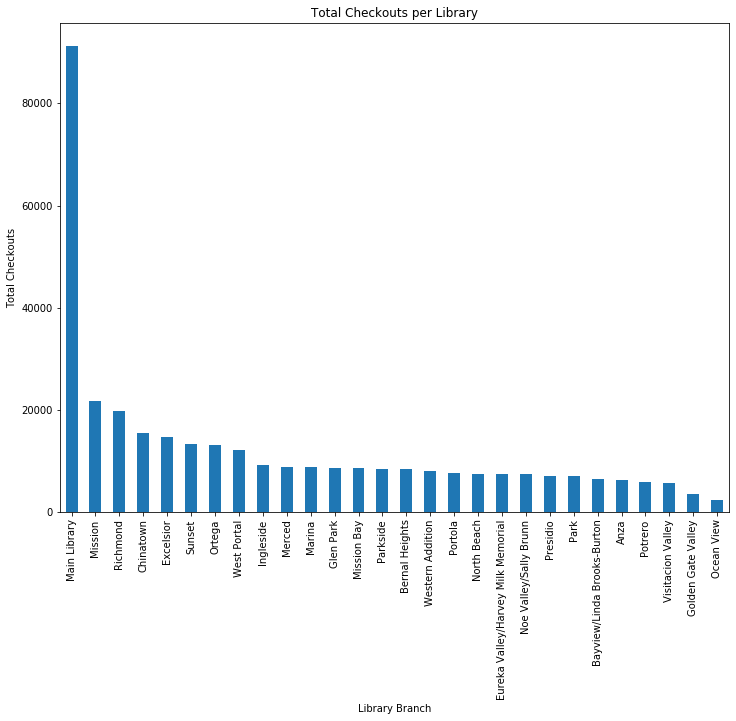

In [133]:
# Main Library for the win. 
# Makes sense, the main library is where most library events go down and has the largest selection of books.
plt.figure(figsize = (12,9));
(df_comp.groupby('home_library_definition').total_checkouts.count().sort_values(ascending = False))[:28].plot(kind = 'bar');
plt.title('Total Checkouts per Library');
plt.xlabel("Library Branch");
plt.ylabel('Total Checkouts');
plt.savefig('ActiveBranch.jpeg', bbox_inches = 'tight' );

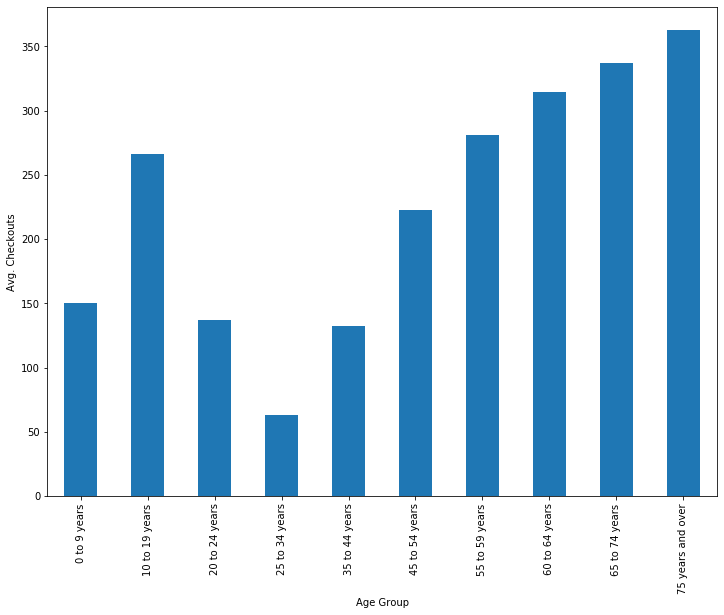

In [137]:
plt.figure(figsize = (12,9));
df_comp.groupby('age_range').total_checkouts.mean().plot(kind = 'bar')
plt.xlabel('Age Group');
plt.ylabel('Avg. Checkouts');
plt.savefig('CheckoutsperAge.jpeg', bbox_inches = 'tight' );


In [289]:
# At first glance, it looks like, for the most part,the older the patron, the more checkouts.
# but this could also be a function of how many years a patron has been active
# Therefore, to get a real gauge of which age group really checks out the most books
# I want to compute the average checkouts/years active 
# assuming the current year is 1 yr more than the maximum year noted in the dataset

In [86]:
#play with active years instead of all years
df_comp['years_active'] = (df_comp.circulation_active_year- df_comp.year_patron_registered)+1


In [87]:
df_comp["yearly_checkouts"] = np.round(df_comp.total_checkouts/df_comp.years_active)


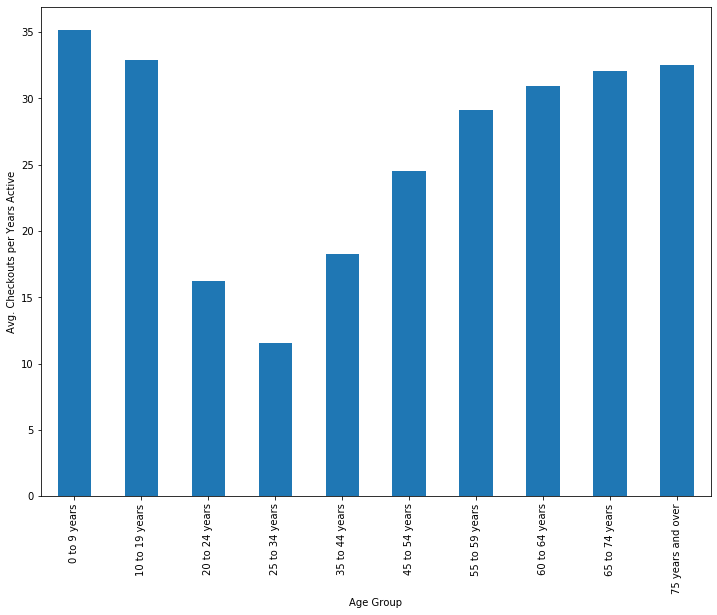

In [138]:
plt.figure(figsize = (12,9));
df_comp.groupby('age_range').yearly_checkouts.mean().plot(kind ='bar');
plt.xlabel('Age Group');
plt.ylabel('Avg. Checkouts per Years Active');
plt.savefig('YearlyCheckoutsperAge.jpeg', bbox_inches = 'tight' );

In [89]:
df_comp.groupby('age_range').yearly_checkouts.describe()

,count,mean,std,min,25%,50%,75%,max
age_range,,,,,,,,
0 to 9 years,33469.0,35.473095,52.026428,0.0,6.0,16.0,43.0,1028.0
10 to 19 years,51226.0,33.301546,52.591871,0.0,4.0,13.0,39.0,858.0
20 to 24 years,23401.0,16.376736,35.510704,0.0,2.0,4.0,14.0,1544.0
25 to 34 years,70721.0,11.706806,26.727687,0.0,2.0,4.0,11.0,1868.0
35 to 44 years,55251.0,18.549384,37.544619,0.0,2.0,7.0,19.0,2565.0
45 to 54 years,43750.0,25.484754,51.488680,0.0,3.0,8.0,25.0,1721.0
55 to 59 years,17432.0,30.672728,62.540456,0.0,3.0,9.0,30.0,1128.0
60 to 64 years,16236.0,32.917652,66.843011,0.0,3.0,10.0,32.0,1290.0
65 to 74 years,24694.0,34.154693,67.688272,0.0,3.0,11.0,36.0,2293.0


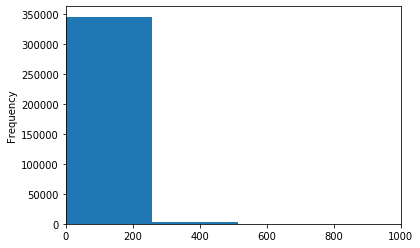

In [90]:
#notice some large variance in yearly checkouts, starting at 500+
df_comp.yearly_checkouts.plot(kind = 'hist', xlim = [0,1000]);


In [91]:
#consider +500 yearly as outliers
df_comp = df_comp[df_comp.yearly_checkouts <= 500]

In [96]:
df_comp.groupby('age_range').yearly_checkouts.describe()

,count,mean,std,min,25%,50%,75%,max
age_range,,,,,,,,
0 to 9 years,33450.0,35.141495,50.063393,0.0,6.0,16.0,43.0,498.0
10 to 19 years,51190.0,32.910510,50.463053,0.0,4.0,13.0,39.0,497.0
20 to 24 years,23398.0,16.264082,33.690793,0.0,2.0,4.0,14.0,477.0
25 to 34 years,70705.0,11.544912,24.013942,0.0,2.0,4.0,11.0,500.0
35 to 44 years,55228.0,18.254708,33.610867,0.0,2.0,7.0,19.0,488.0
45 to 54 years,43684.0,24.508012,44.337257,0.0,3.0,8.0,25.0,500.0
55 to 59 years,17389.0,29.104606,53.404638,0.0,3.0,9.0,30.0,497.0
60 to 64 years,16187.0,30.948230,55.543391,0.0,3.0,9.0,32.0,494.0
65 to 74 years,24618.0,32.099114,54.497072,0.0,3.0,10.0,36.0,499.0


In [93]:
# For the above, there is a definite dip in library usage starting from early 20s to mid 40s age_range. 
# Then a steady climb from there. But still, the oldest members have the highest average checkouts per years active. 
# What about renewals? Because renewals are directly related to checkouts, this look relatively the same as the graph above. 
df_comp['yearly_renewals'] = np.round(df_comp.total_renewals/df_comp.years_active,0)

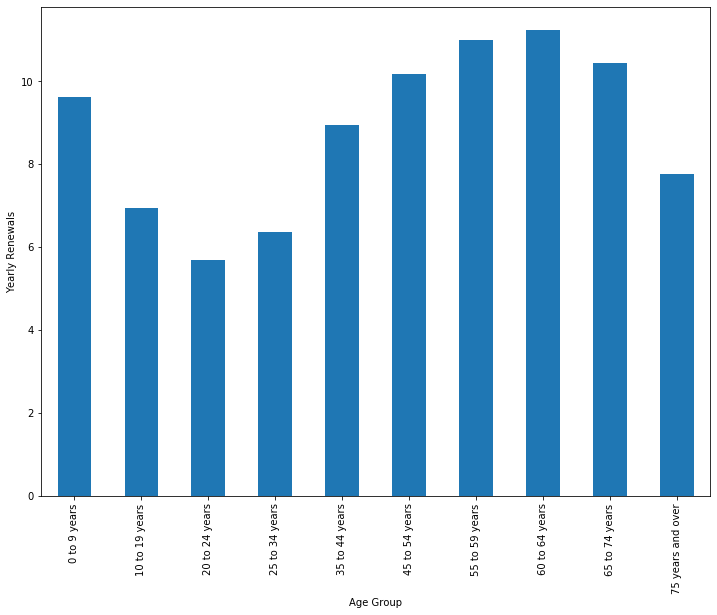

In [139]:
plt.figure(figsize = (12,9));
df_comp.groupby('age_range').yearly_renewals.mean().plot(kind ='bar');

#plt.title('Avg. Yearly Renewals');
plt.xlabel('Age Group');
plt.ylabel('Yearly Renewals');
plt.savefig('YearlyRenewalsperAge.jpeg', bbox_inches = 'tight' );

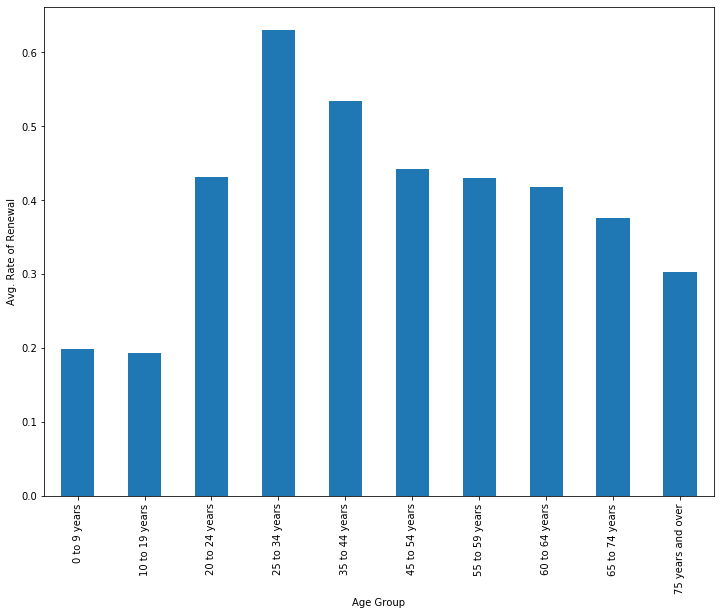

In [140]:
# Interesting, when looking at renewals the highest group is not 60-64 years and the 75 and older is brought 
# down to fifth highest.
# Let's take a look at renewals per checkouts. Because the data does not provide specifics about any particular
# checkout, this again will have to be computed as an average=
# total_renewals/ total_checkouts 
df_comp['renewal_rate'] = np.round(df_comp.total_renewals/df_comp.total_checkouts,1)

plt.figure(figsize = (12,9));
df_comp.groupby('age_range').renewal_rate.mean().plot(kind ='bar');
plt.xlabel('Age Group');
plt.ylabel('Avg. Rate of Renewal');
plt.savefig('RenewalRateperAge.jpeg', bbox_inches = 'tight' );

In [298]:
df_comp.groupby('age_range').renewal_rate.describe()

,count,mean,std,min,25%,50%,75%,max
age_range,,,,,,,,
0 to 9 years,33469.0,0.199537,0.403408,0.0,0.0,0.0,0.2,6.5
10 to 19 years,51226.0,0.193396,0.350184,0.0,0.0,0.1,0.2,6.0
20 to 24 years,23401.0,0.430721,0.701912,0.0,0.0,0.1,0.6,8.5
25 to 34 years,70721.0,0.629714,0.821156,0.0,0.0,0.3,1.0,7.0
35 to 44 years,55251.0,0.534313,0.692685,0.0,0.0,0.3,0.8,6.7
45 to 54 years,43750.0,0.441783,0.595444,0.0,0.0,0.2,0.6,9.0
55 to 59 years,17432.0,0.429761,0.579710,0.0,0.0,0.2,0.6,6.0
60 to 64 years,16236.0,0.416605,0.555163,0.0,0.0,0.2,0.6,6.0
65 to 74 years,24694.0,0.374868,0.525155,0.0,0.0,0.2,0.5,7.0


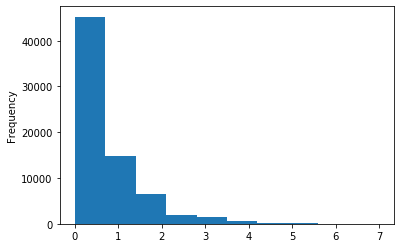

In [100]:
#plot some histograms to get more of a feel for the spread
df_comp[df_comp.age_range == "25 to 34 years"].renewal_rate.plot(kind = "hist");

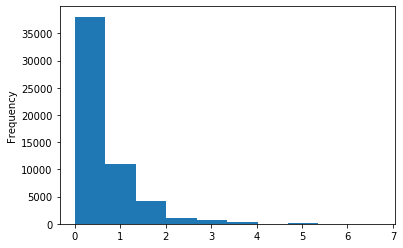

In [101]:
df_comp[df_comp.age_range == "35 to 44 years"].renewal_rate.plot(kind = "hist");

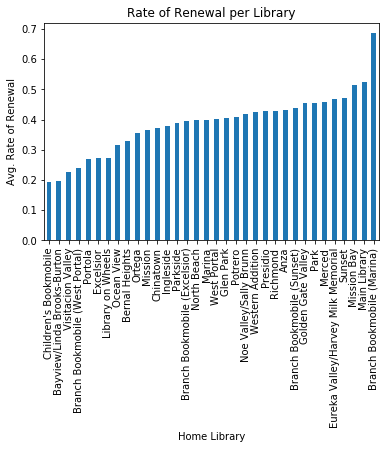

In [104]:
# ok so now I know that if the book has been checked out by a 20 something, I might have to wait an average of 2 - 9 days 
# more than if any other age group has the group
# how does home_library affect this?
df_comp.groupby('home_library_definition').renewal_rate.mean().sort_values().plot(kind = 'bar');
plt.xlabel ('Home Library');
plt.ylabel('Avg. Rate of Renewal');
plt.title('Rate of Renewal per Library');

In [107]:
df_comp[df_comp.home_library_definition == "Mission Bay"].groupby('age_range').patron_type_definition.count()

age_range
0 to 9 years          721
10 to 19 years        481
20 to 24 years        410
25 to 34 years       2596
35 to 44 years       2213
45 to 54 years       1091
55 to 59 years        341
60 to 64 years        283
65 to 74 years        410
75 years and over     159
Name: patron_type_definition, dtype: int64

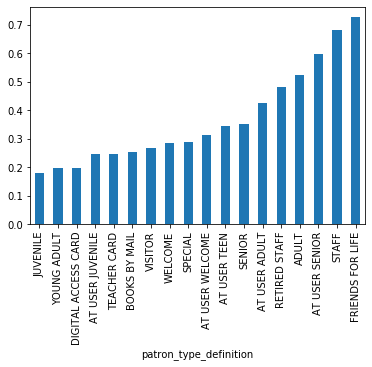

In [108]:
#lets take a look at patron type
df_comp.groupby("patron_type_definition").renewal_rate.mean().sort_values().plot(kind = 'bar');


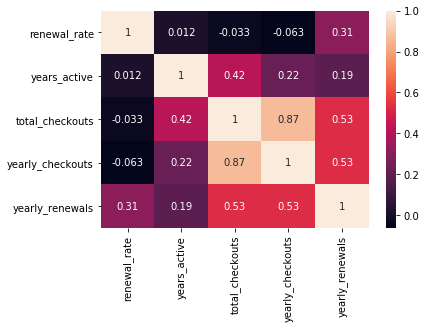

In [109]:
sns.heatmap(df_comp[['renewal_rate','years_active', 'total_checkouts', 'yearly_checkouts', 'yearly_renewals']].corr(), annot = True);

## Model

In [307]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe 
    '''
    
    df = pd.get_dummies(df, columns = cat_cols, dummy_na = dummy_na, drop_first= True)

    return df

In [308]:
def clean_fit_linear_mod(df,response_col, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    '''
   # df_drop = df.dropna(subset = [response_col], axis = 0)
   # df_drop_na = df_drop.loc[:,((df_drop.isna().sum()/df_drop.shape[0]) == 1)== False]
    cat_df = df.select_dtypes(include = ['object', 'category'])
    cat_cols = cat_df.columns

    df_dummy = create_dummy_df(df, cat_cols, dummy_na = dummy_na)

    #fill_mean = lambda col: col.fillna(col.mean())

    #df_dummy_fill = df_dummy.apply(fill_mean, axis = 0)

    X = df_dummy.drop(response_col, axis = 1)
    y = df_dummy[response_col]

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = test_size, random_state = rand_state)

    lm_model = LinearRegression(normalize = True)
    lm_model.fit(X_train,y_train)
    y_preds = lm_model.predict(X_test)
    test_score = r2_score(y_test, y_preds)
    y_preds_train = lm_model.predict(X_train)
    train_score = r2_score(y_train, y_preds_train)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test


In [366]:
df_model1 = (df_comp[['years_active','patron_type_definition','home_library_definition','age_range','yearly_checkouts','renewal_rate']])

In [367]:
test_score_1, train_score_1, lm_model_1, X_train_1, X_test_1, y_train_1, y_test_1 = clean_fit_linear_mod(df_model1,'renewal_rate', dummy_na=False, test_size=.3, rand_state=42);

In [368]:
test_score_1,train_score_1

(0.07462600244216311, 0.07382270848946626)

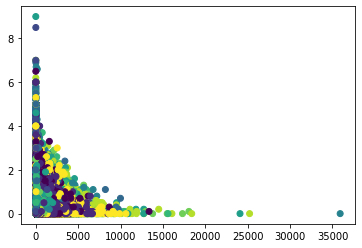

In [322]:
#PLOTS
plt.scatter(x = df_comp.total_checkouts, y = df_comp.renewal_rate.multiply(2*0.5).round(1)
            , c= df_comp.age_range.cat.codes)


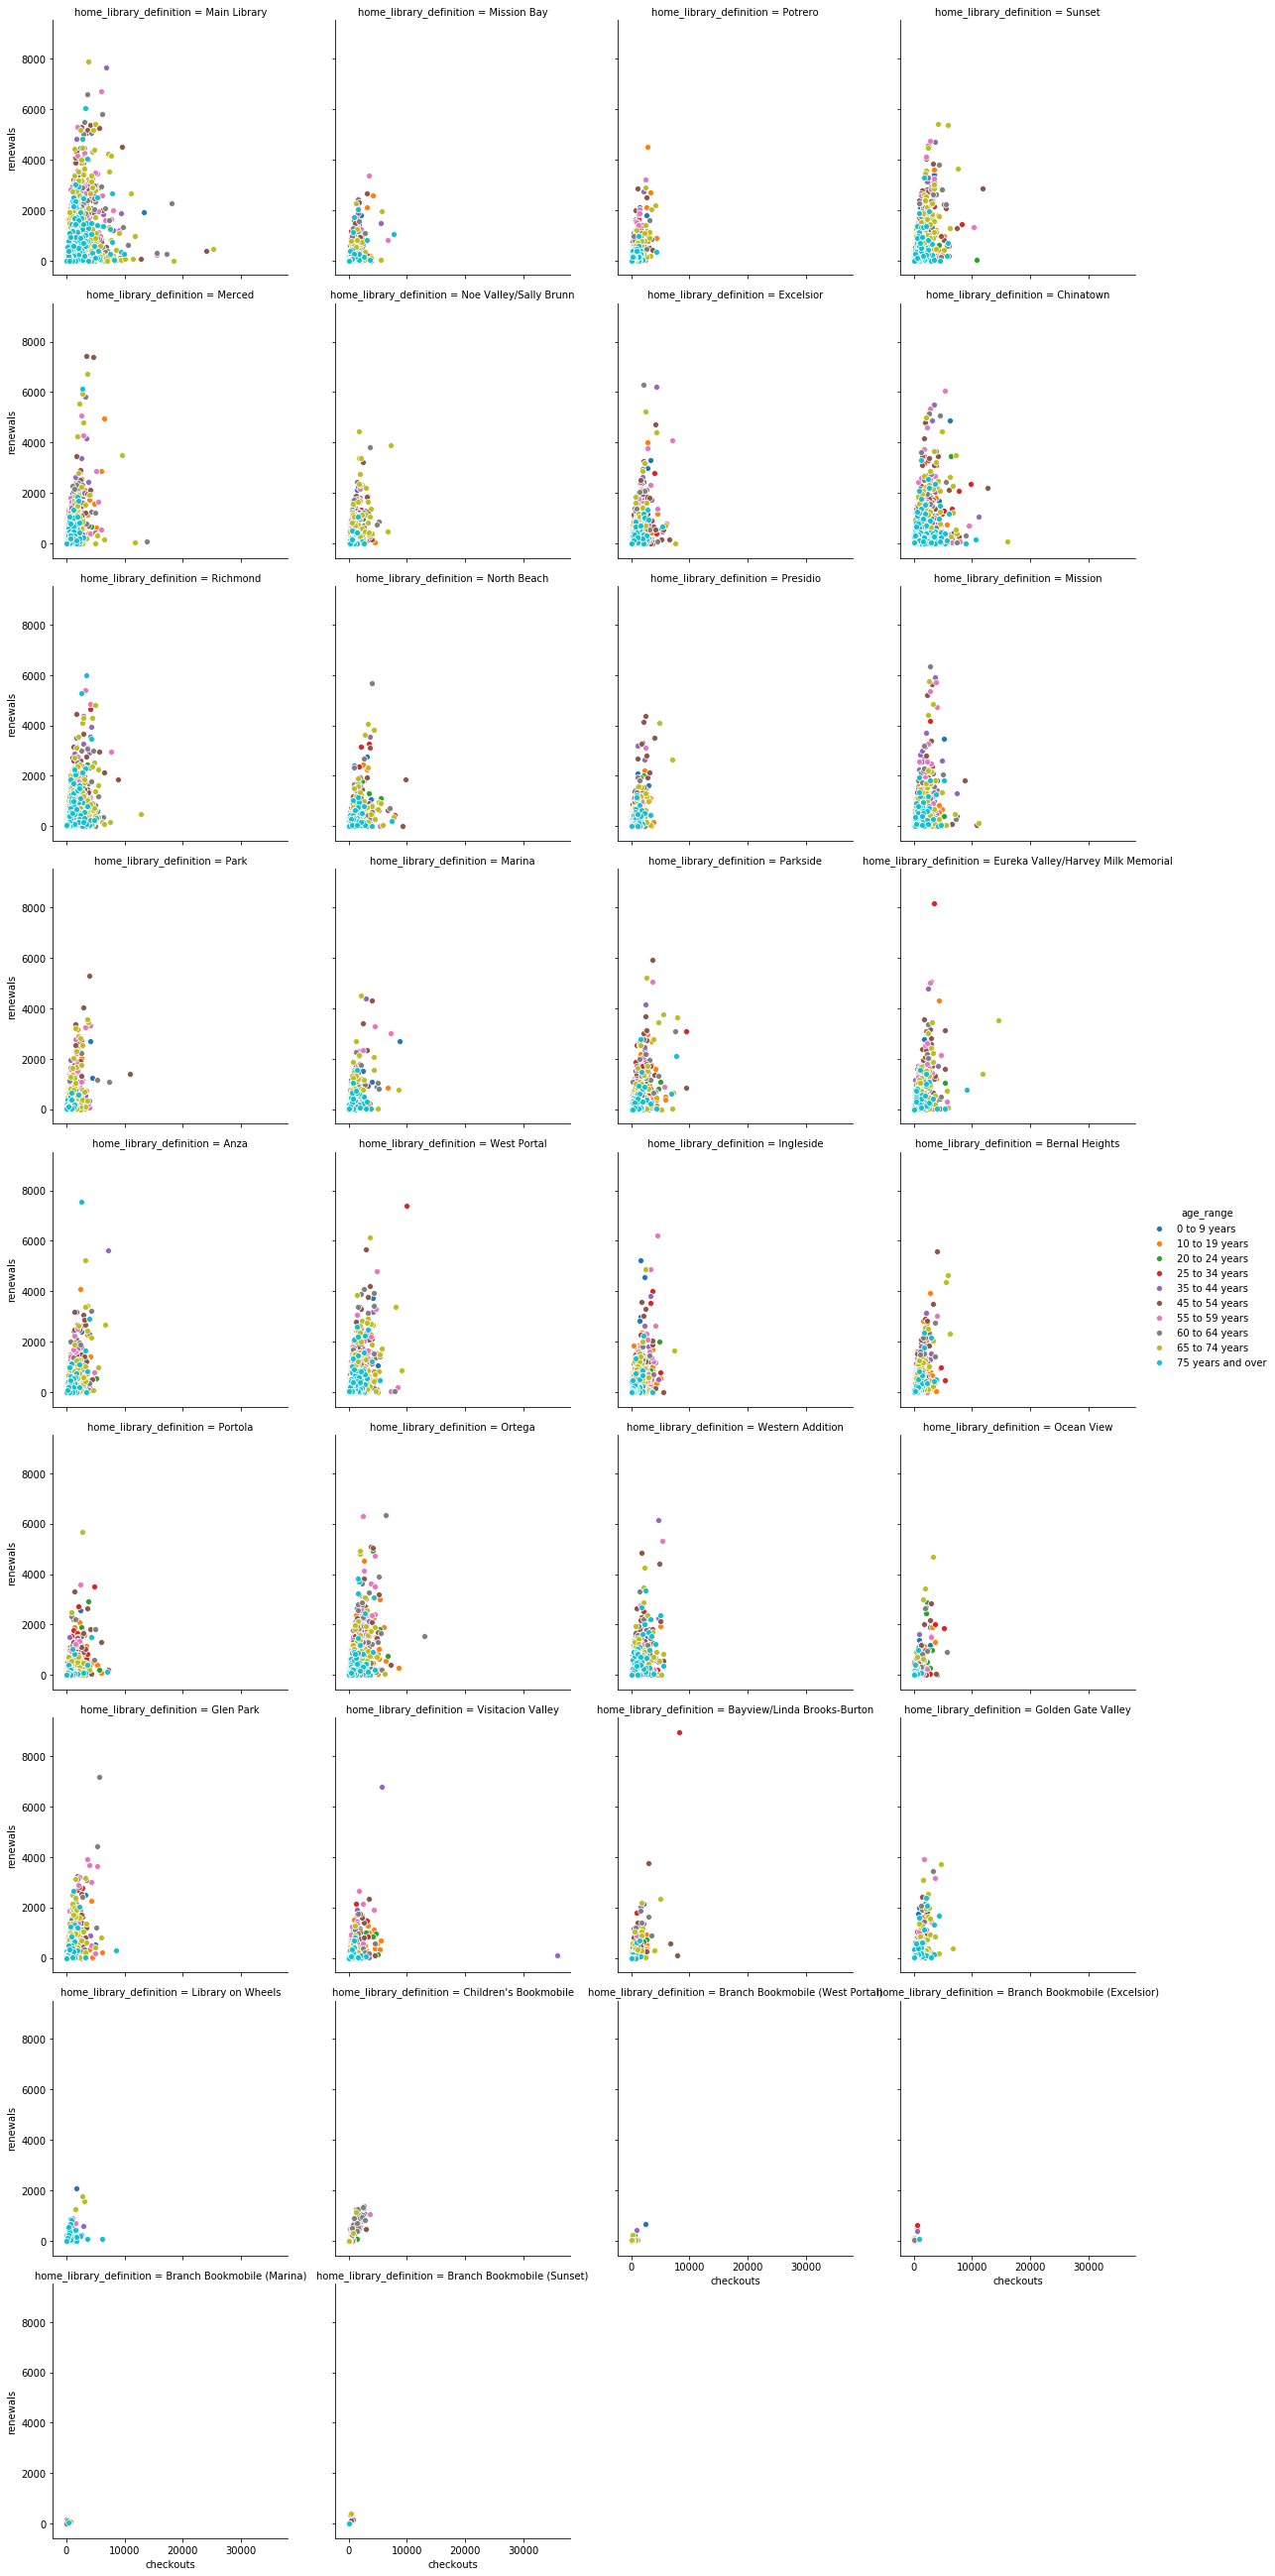

In [330]:
plt1 = sns.FacetGrid(df_comp, col="home_library_definition", hue="age_range", height = 4, col_wrap=4);
plt1.map_dataframe(sns.scatterplot, x="total_checkouts", y="total_renewals");
plt1.set_axis_labels("checkouts", "renewals");
plt1.add_legend();